In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix



from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive
from astroquery.mast import Catalogs
import astropy.units as u
from astropy.coordinates import SkyCoord

import pandas as pd
import numpy as np
import requests

In [2]:
# Query the KOI table

koi_table = NasaExoplanetArchive.query_criteria(table="koi", select='*', cache=True)
koi_df = koi_table.to_pandas()

In [3]:
# Select relevant columns

selected_columns = [
    'kepid', 'ra', 'dec', 'koi_disposition', 'koi_score',
    'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_smet'
]
koi_selected = koi_df[selected_columns]

In [5]:
print(koi_selected.head())

      kepid         ra        dec koi_disposition  koi_score  koi_period  \
0  10797460  291.93423  48.141651       CONFIRMED      1.000    9.488036   
1  10797460  291.93423  48.141651       CONFIRMED      0.969   54.418383   
2  10811496  297.00482  48.134129       CANDIDATE      0.000   19.899140   
3  10848459  285.53461  48.285210  FALSE POSITIVE      0.000    1.736952   
4  10854555  288.75488  48.226200       CONFIRMED      1.000    2.525592   

   koi_time0bk  koi_duration  koi_depth  koi_prad  koi_teq  koi_insol  \
0   170.538750       2.95750      615.8      2.26    793.0      93.59   
1   162.513840       4.50700      874.8      2.83    443.0       9.11   
2   175.850252       1.78220    10829.0     14.60    638.0      39.30   
3   170.307565       2.40641     8079.2     33.46   1395.0     891.96   
4   171.595550       1.65450      603.3      2.75   1406.0     926.16   

   koi_model_snr  koi_steff  koi_slogg  koi_srad  koi_smass  koi_smet  
0           35.8     5455.0     

In [ ]:
print(koi_selected['koi_disposition'].unique())

['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE' 'NOT DISPOSITIONED']
koi_disposition
FALSE POSITIVE       21168
CONFIRMED            20609
CANDIDATE             8803
NOT DISPOSITIONED     4075
Name: count, dtype: int64


In [8]:
# Create a 


koi_selected['label'] = koi_selected['koi_disposition'].map({
    'CONFIRMED': 1,
    'FALSE POSITIVE': 0
})
koi_selected = koi_selected[koi_selected['label'].isin([0, 1])]
print(koi_selected['label'].value_counts())


label
0.0    21168
1.0    20609
Name: count, dtype: int64


/var/folders/b6/5kj2tkgn6vx8kxcyhfg6pf9c0000gn/T/ipykernel_7797/1991945611.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  koi_selected['label'] = koi_selected['koi_disposition'].map({


In [9]:
# Dump null records, if any

print(koi_selected.isnull().sum())
koi_cleaned = koi_selected.dropna()
koi_cleaned = koi_cleaned.reset_index(drop=True)
print(koi_cleaned['label'].value_counts())

kepid              0
ra                 0
dec                0
koi_disposition    0
koi_score          0
koi_period         0
koi_time0bk        0
koi_duration       0
koi_depth          0
koi_prad           0
koi_teq            0
koi_insol          0
koi_model_snr      0
koi_steff          0
koi_slogg          0
koi_srad           0
koi_smass          0
koi_smet           0
label              0
dtype: int64
label
0.0    21168
1.0    20609
Name: count, dtype: int64


In [ ]:
# assign features

feature_columns = [
    'koi_period', 'koi_time0bk', 'koi_duration', 'koi_depth',
    'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr',
    'koi_steff', 'koi_slogg', 'koi_srad', 'koi_smass', 'koi_smet'
]
X = koi_cleaned[feature_columns]
y = koi_cleaned['label']


In [11]:
X = X.apply(pd.to_numeric, errors='coerce')

X = X.dropna()
y = y[X.index]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [ ]:
# Normalize data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [ ]:
# Initialize classifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Eval

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.93      4235
         1.0       0.92      0.93      0.92      4121

    accuracy                           0.93      8356
   macro avg       0.93      0.93      0.93      8356
weighted avg       0.93      0.93      0.93      8356

[[3891  344]
 [ 280 3841]]


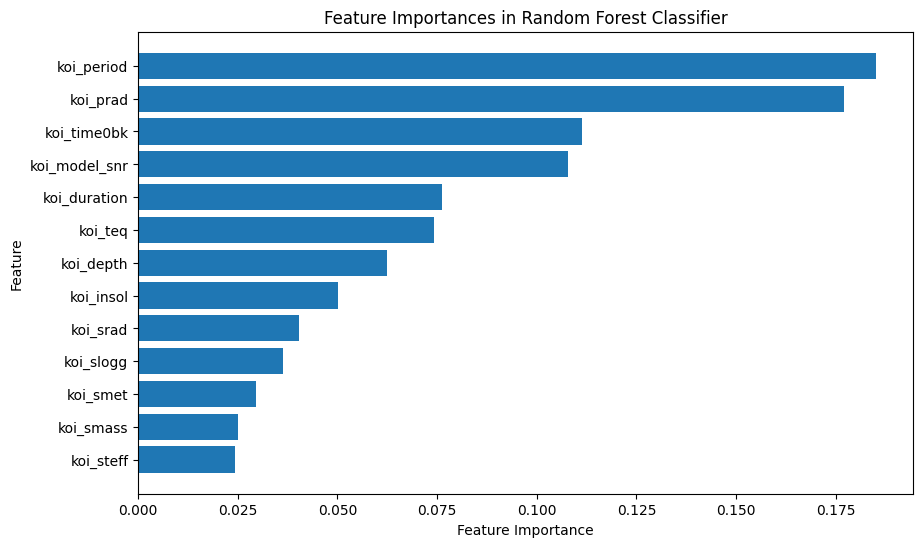

In [ ]:
import matplotlib.pyplot as plt

importances = clf.feature_importances_
feature_names = feature_columns
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.title('Feature Importances in Random Forest Classifier')
plt.show()

In [ ]:
# Perform cross-validation

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(clf, X_scaled, y, cv=skf)
print("Stratified Cross-validation scores:", cv_scores)
print("Mean stratified cross-validation score:", cv_scores.mean())


Stratified Cross-validation scores: [0.92939205 0.92999043 0.92663076 0.92986236 0.92531418]
Mean stratified cross-validation score: 0.9282379561345385


In [22]:
# hyperparameter tuning using Grid Search

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2,
    scoring='f1'
)

grid_search.fit(X, y)

print("Best parameters found: ", grid_search.best_params_)
# Best estimator
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s[CV] END bootst

/Users/crashy/.local/share/virtualenvs/exoproximo-5nyzYu3C/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  13.9s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=50; total time=   3.5s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=   3.3s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  13.8s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=sqrt, 

/Users/crashy/.local/share/virtualenvs/exoproximo-5nyzYu3C/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
2160 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1088 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/crashy/.local/share/virtualenvs/exoproximo-5nyzYu3C/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/crashy/.local/share/virtualenvs/exoproximo-5nyzYu3C/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/crashy/.local/share/virtualenv

Best parameters found:  {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [25]:
# Split the data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

best_params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

optimized_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    criterion=best_params['criterion'],
    random_state=42  # Set random_state for reproducibility
)
optimized_rf.fit(X_train, y_train)

y_pred = optimized_rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Slightly better result

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      4234
         1.0       0.93      0.93      0.93      4122

    accuracy                           0.93      8356
   macro avg       0.93      0.93      0.93      8356
weighted avg       0.93      0.93      0.93      8356

[[3926  308]
 [ 288 3834]]
